In [40]:
# Reference: https://jupyterbook.org/interactive/hiding.html
# Use {hide, remove}-{input, output, cell} tags to hiding content

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display
import myst_nb

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 8)
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

def display_df(df, rows=pd.options.display.max_rows,
               cols=pd.options.display.max_columns):
    with pd.option_context('display.max_rows', rows,
                           'display.max_columns', cols):
        display(df)
        
# businesses
bus = pd.read_csv('data/businesses.csv', encoding='ISO-8859-1')

# inspections
insp = pd.read_csv("data/inspections.csv")

insp['new_date'] = insp['date'].apply(lambda d: pd.datetime.strptime(str(d),'%Y%m%d'))
insp['year']     = insp['new_date'].apply(lambda d: d.year)

# violations
viol = pd.read_csv("data/violations.csv")
viol['new_date'] = viol['date'].apply(lambda d: pd.datetime.strptime(str(d),'%Y%m%d'))
viol['year']     = viol['new_date'].apply(lambda d: d.year)


<ipython-input-40-03108d38c012>:35: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  insp['new_date'] = insp['date'].apply(lambda d: pd.datetime.strptime(str(d),'%Y%m%d'))
<ipython-input-40-03108d38c012>:40: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  viol['new_date'] = viol['date'].apply(lambda d: pd.datetime.strptime(str(d),'%Y%m%d'))


(ch:wrangling_restaurants)=
# Example: Wrangling Restaurant Safety Violations

The violations dataset contains detailed information about the violations found during an inspection. We would like to capture some of this information and add it to the inspection-level dataset that has the inspection score. 

As a first step, let's simplify the structure by reducing the rows to those inspections from one year. Recall that this dataset contains four years of inspection information.  Below we tally the number of records for each year.

In [41]:
pd.value_counts(insp['year'])

2016    5443
2017    5166
2015    3305
2018     308
Name: year, dtype: int64

Let's take a subset of the data from the most recent year, 2016. When we reduce the data frame to those records from 2016 we create a copy of the portion of the data frame because...

In [42]:
vio2016 = viol[viol['year']==2016].copy()
ins2016 = insp[insp['year']==2016]

Let's examine the heads of the two files again to familiarize ourselves with the data again. 

In [43]:
ins2016.head()

,business_id,score,date,type,new_date,year
0,19,94,20160513,routine,2016-05-13,2016
3,24,98,20161005,routine,2016-10-05,2016
4,24,96,20160311,routine,2016-03-11,2016
6,45,78,20160104,routine,2016-01-04,2016
9,45,84,20160614,routine,2016-06-14,2016


Recall that `new_data` is a `datetime` formatted variable, and the business_id along with new_date uniquely identifies the inspections. Notice that business \#24 had two inspections in 2016, one in March and another in October. 

In [44]:
vio2016.head(5)

,business_id,date,description,new_date,year
2,19,20160513,Unapproved or unmaintained equipment or utensi...,2016-05-13,2016
3,19,20160513,Unclean or degraded floors walls or ceilings ...,2016-05-13,2016
4,19,20160513,Food safety certificate or food handler card n...,2016-05-13,2016
6,24,20161005,Unclean or degraded floors walls or ceilings ...,2016-10-05,2016
7,24,20160311,Unclean or degraded floors walls or ceilings ...,2016-03-11,2016


Notice that the first five records in the violations data frame are all for the same restaurant. One transformation that might prove useful in understanding the score is the count of the number of violations found in a single inspection and add this new feature to the inspections data frame. To count up the violations per inspection we change the granularity of the violations data frame to match the inspections data frame (that is, to group together all records for the same restaurant inspection), and calculate the size of teach group.  

In [45]:
num_vios = (vio2016.groupby(['business_id', 'new_date']).size()
            .reset_index()
            .rename(columns={0: 'num_vio'}));

Now we want to merge num_vios with `ins2016`. What kind of merge do we want to perform? We want a left join of `ins2016` with `num_vios` because there could be inspections that do not have any violations.

In [46]:
joined_dataR = ins2016.merge(num_vios, on=['business_id', 'new_date'], how='left')

When there are no violations for an inspection, the feature `num_vio` will be missing. We can check how many NULL values are in this feature. 

In [47]:
joined_dataR['num_vio'].isnull().sum()

833

If a score is 100, then we wouldn't expect any violations, and we can correct these missing values by setting them to 0. We are using deductive imputation here.

In [48]:
joined_dataR.loc[joined_dataR.score == 100, 'num_vio'] = 0

In [49]:
joined_dataR.head()

,business_id,score,date,type,new_date,year,num_vio
0,19,94,20160513,routine,2016-05-13,2016,3.0
1,24,98,20161005,routine,2016-10-05,2016,1.0
2,24,96,20160311,routine,2016-03-11,2016,2.0
3,45,78,20160104,routine,2016-01-04,2016,7.0
4,45,84,20160614,routine,2016-06-14,2016,5.0


When we check again, there are now only about 65.

In [50]:
joined_dataR['num_vio'].isnull().sum()

65

We have corrected a large number of missing values. With further investigation, we find that some of the businesses have inspection dates in `ins2016` that differ from the dates in `vio2016` by one or two days. We could change the dates in `vio2016`, if we wanted to fix additional missing data. We leave that to an exercise. 

Let's examine the relationship between the number of violations and the inspection score.

<AxesSubplot:xlabel='num_vio', ylabel='score'>

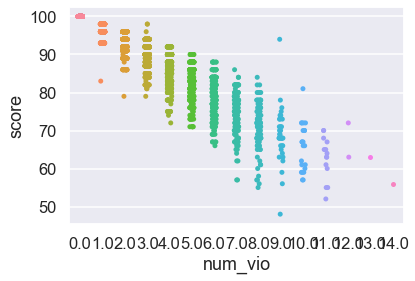

In [51]:
sns.stripplot(x="num_vio", y="score", jitter=True, data=joined_dataR)

As we might expect there is a negative relationship between the inspection score and the number of violations found during the inspection. The variability in the score appears greater for lower scores.  Undoubtedly, not all violations impact the score the same amount.  

How can we use the information in the description of the violation to capture the kind of violation that has occurred?

We saw earlier that the feature description in the violations data frame has a lot of text, including information in square brackets about when the violation was corrected. We can tally the descriptions and examine the most "popular" violations.

In [52]:
vio2016['description'].value_counts().head(20)

Unclean or degraded floors walls or ceilings        161
Unapproved or unmaintained equipment or utensils     99
Moderate risk food holding temperature               95
                                                   ... 
Improper or defective plumbing                       28
Inadequate ventilation or lighting                   26
Unclean or unsanitary food contact surfaces          23
Name: description, Length: 20, dtype: int64

These descriptions are long and wordy. Reading through these descriptions, we see that some are related to the cleanliness of facilities, others are related to the food storage, and still others pertain to the cleanliness of the staff.  We are interested in the basic gist of the violations.  For example, if a description contains the term "high risk" then we can create a feature, called isHighRisk, that is True or False depending on whether or not the description contains the term. 

Below, we create eights new features that we have developed to give us a sense of the kind of violation that has occurred.  Don't worry about the particular details of the code. Basically, each feature is True/False according to the presence/absence of specific words in the description.

In [53]:
vio2016['isHighRisk'] = vio2016['description'].str.contains(r"high risk")
vio2016['isClean'] = vio2016['description'].str.contains(r"clean|sanit")
surface = vio2016['description'].str.contains(r"surface")
food = vio2016['description'].str.contains(r"\Wfood")
vio2016['isFoodSurface'] = (surface & food)
vio2016['isVermin'] = vio2016['description'].str.contains(r"vermin")
vio2016['isStorage'] = vio2016['description'].str.contains(r"thaw|cool|therm|storage")
vio2016['isDisplayPermit'] = vio2016['description'].str.contains(r"certificate|permit")
vio2016['isNonFoodSurface'] = vio2016['description'].str.contains(r"wall|ceiling|floor|surface")
vio2016['isHuman'] = vio2016['description'].str.contains(r"hand|glove|hair|nail")

Now that we have these new features in `vio2016`, we again want to merge this information with the inspection information. We roll up the violations again to the restaurant/date level and track whether any of the values in the group is True or not. 

In [54]:
features = vio2016.groupby(['business_id', 'new_date'])[['isClean', 'isFoodSurface', 'isVermin',
                                                'isStorage', 'isDisplayPermit', 'isHuman',
                                                'isNonFoodSurface', 'isHighRisk']].max()
features.head()

isClean  isFoodSurface  isVermin  isStorage  \
business_id new_date                                                  
19          2016-05-13     True          False     False      False   
24          2016-03-11     True          False     False      False   
            2016-10-05     True          False     False      False   
45          2016-01-04     True           True     False      False   
            2016-06-14     True          False      True      False   

                        isDisplayPermit  isHuman  isNonFoodSurface  isHighRisk  
business_id new_date                                                            
19          2016-05-13             True     True              True       False  
24          2016-03-11            False    False              True       False  
            2016-10-05            False    False              True       False  
45          2016-01-04            False     True              True       False  
            2016-06-14            False    False              True       False

Again, we use a left join to merge these new features into the inspection-level data frame, `joined_dataR`. And, for the special case of a score of 100, we set each of the new features to False.

In [55]:
joined_dataB = joined_dataR.merge(features, on=['business_id', 'new_date'], how='left')

feature_names = features.columns.values

i = 1
for f in feature_names:
    joined_dataB.loc[joined_dataB.score == 100, f] = False
    i += 1

We can check our transformations  with a collection of boxplots that compares the distribution of the inspection score each violation type.  

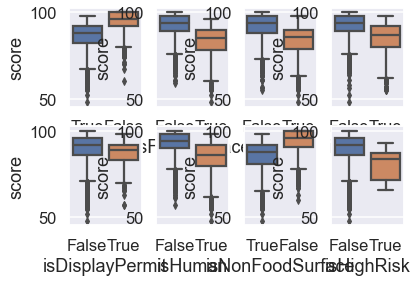

In [56]:
i = 1
for f in feature_names:
    plt.subplot(2, 4, i)
    sns.boxplot(y="score", x=f, data=joined_dataB)
    i += 1

A few observations about these boxplots: restaurants that have no cleanliness-related violations have the highest scores; having a display permit violation isn't much of a detractor; high risk violations lower the distribution of scores more than any other violation. These observations are just the beginning of a possible analysis into understanding what a score means.

This example has shown how text has the potential to be used in a data analysis. We can derive analyzable features from text. There are other techniques for converting text into data that can be analyzed statistically (see {numref}`Chapter %s <ch:text>`).